In [1]:
import os
import re
import glob
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict, Counter
import sentencepiece as spm
import matplotlib.pyplot as plt
import psutil
from Bio.Seq import Seq
from Bio import SeqIO
import subprocess

In [2]:
genome_sequences_dir = "genome_sequences"
tokenizers_dir = "tokenizers"
subsampled_genomes_dir = "subsampled_genomes"
os.makedirs(subsampled_genomes_dir, exist_ok=True)
os.makedirs(tokenizers_dir, exist_ok=True)

org = "Nanobdella aerobiophila"
genome_filename = f"{org.replace(' ', '_')}_processed.txt"

def print_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    print(f"mem usage: {mem_info.rss / 1024 ** 2:.2f} mb")

def load_genome_sequence(filename):
    start_time = time.time()
    with open(os.path.join(genome_sequences_dir, filename), 'r') as f:
        genome = f.read().upper().replace('\n', '')
    end_time = time.time()
    print(f"Loaded genome sequence in {end_time - start_time:.2f} seconds")
    return genome


def subsample_genome(genome, size=10**6): 
    return genome[:min(size, len(genome))]

def save_subsampled_genome(org, subsample):
    subsample_path = os.path.join(subsampled_genomes_dir, f"{org.replace(' ', '_')}_subsampled.txt")
    with open(subsample_path, 'w') as f:
        f.write(subsample)
    return subsample_path

In [3]:
"""calculate the compression factor, and then train the sentencepiece tokenizer. """

def calculate_compression_factor(genome, tokens, vocab):
    total_length = len(genome)
    encoded_length = len(tokens)
    vocab_length = sum(len(token) for token in vocab)
    compression_factor = (encoded_length + vocab_length) / total_length
    return compression_factor

def train_sentencepiece_tokenizer(input_file, model_prefix, vocab_size):
    spm.SentencePieceTrainer.train(
        input=input_file,
        model_prefix=model_prefix,
        vocab_size=vocab_size,
        model_type='bpe',
        character_coverage=0.9995,
        max_sentence_length=1000000
    )

def load_and_tokenize(model_path, sequence):
    sp = spm.SentencePieceProcessor(model_file=model_path)
    tokens = sp.encode_as_pieces(sequence)
    return tokens


In [4]:
"""functions for generating k-mers, counting their frequencies, and creating a vocabulary. basically, we chop up the dna into little pieces (kmers), 
count how often each piece shows up, and then make a top-k list of the most popular pieces. like making a greatest hits album, but for dna."""

def generate_kmers(sequence, k):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

def calculate_kmer_frequencies(sequence, k):
    start_time = time.time()
    kmer_freqs = defaultdict(int)
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i+k]
        kmer_freqs[kmer] += 1
    end_time = time.time()
    print(f"Calculated k-mer frequencies in {end_time - start_time:.2f} seconds")
    return kmer_freqs

def create_vocabulary(kmer_freqs, vocab_size):
    sorted_kmers = sorted(kmer_freqs.items(), key=lambda x: x[1], reverse=True)
    vocab = [kmer for kmer, _ in sorted_kmers[:vocab_size]]
    return vocab


In [5]:
"""this function tries to find the best vocab size for the tokenizer. it tries dif sizes, trains the tokenizer, and checks how well it compresses the genome."""

def heuristic_search_optimal_vocab_size(genome, processed_genome_path, kmer_freqs, initial_vocab_size=1000, step_size=1000, max_vocab_size=80000):  
    vocab_sizes = list(range(initial_vocab_size, max_vocab_size + step_size, step_size))
    best_vocab_size = initial_vocab_size
    best_compression_factor = float('inf')
    compression_factors = []

    for vocab_size in vocab_sizes:
        model_prefix = os.path.join(tokenizers_dir, f"sentencepiece_bpe_{vocab_size}")
        try:
            train_sentencepiece_tokenizer(processed_genome_path, model_prefix, vocab_size)
        except RuntimeError as e:
            if "Vocabulary size too high" in str(e):
                print(f"Vocabulary size {vocab_size} too high, reducing and retrying...")
                    # extract the maximum possible vocab size from the error message
                max_possible_vocab_size = int(str(e).split()[-1][:-1])  
                if vocab_size > max_possible_vocab_size:
                    vocab_size = max_possible_vocab_size
                    train_sentencepiece_tokenizer(processed_genome_path, model_prefix, vocab_size)
            else:
                raise e

        model_file = f"{model_prefix}.model"
        tokens = load_and_tokenize(model_file, genome)
        vocab = create_vocabulary(kmer_freqs, vocab_size)
        compression_factor = calculate_compression_factor(genome, tokens, vocab)
        compression_factors.append((vocab_size, compression_factor))
        print(f'Vocab size: {vocab_size}, Compression factor: {compression_factor}')
        if compression_factor < best_compression_factor:
            best_compression_factor = compression_factor
            best_vocab_size = vocab_size

    return best_vocab_size, best_compression_factor, compression_factors

In [6]:
def plot_results(compression_factors):
    vocab_sizes, compression_values = zip(*compression_factors)
    plt.plot(vocab_sizes, compression_values)
    plt.xlabel('vocab size')
    plt.ylabel('compression factor')
    plt.title('compression factor vs vocab size')
    plt.show()

def plot_token_length_distribution(tokens):
    token_lengths = [len(token) for token in tokens]
    plt.hist(token_lengths, bins=np.arange(0, max(token_lengths) + 1))
    plt.xlabel('Token Length')
    plt.ylabel('Frequency')
    plt.title('Token Length Distribution')
    plt.show()

def plot_rank_frequency_curve(tokcounts):
    frequencies = [count for token, count in tokcounts]
    plt.plot(np.arange(1, len(frequencies) + 1), frequencies)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.title('Rank-Frequency Curve')
    plt.show()    

In [7]:
"""convert genome sequences to fasta format, then find the orfs using orfipy, load the orf data, process it to extract all orf data, save it in an excel file, 
and mark the orf positions in the genome sequence. align them with kmers to see where they overlap.this helps us identify which parts of the genome are coding and non-coding. 
by analyzing the overlap, we can understand the distribution and frequency of kmers in coding versus non-coding regions (i think lol)"""

def convert_to_fasta(org):
    org_filename = org.replace(' ', '_')
    input_path = os.path.join(genome_sequences_dir, f"{org_filename}_processed.txt")
    fasta_path = os.path.join(genome_sequences_dir, f"{org_filename}.fasta")
    
    with open(input_path, 'r') as infile, open(fasta_path, 'w') as outfile:
        sequence = infile.read().strip()
        outfile.write(f">{org_filename}\n")
        for i in range(0, len(sequence), 80):
            outfile.write(sequence[i:i+80] + "\n")
    
    print(f"converted {input_path} to {fasta_path}")
    return fasta_path

def find_orfs(org):
    org_filename = org.replace(' ', '_')
    fasta_path = convert_to_fasta(org)
    orf_output_dir = os.path.join(genome_sequences_dir, f"{org_filename}_orfs")
    os.makedirs(orf_output_dir, exist_ok=True)
    
    try:
        result = subprocess.run(
            ['orfipy', fasta_path, '--min', '100', '--max', '5000'],
            capture_output=True, text=True, check=True
        )
        print(f"ORFipy ran successfully for {fasta_path}")
    except subprocess.CalledProcessError as e:
        print(f"Error running ORFipy: {e}")
        print(e.stdout)
        print(e.stderr)
        return None
    
    orf_output = result.stdout
    orf_output_path = os.path.join(orf_output_dir, f"{org_filename}.txt")
    with open(orf_output_path, 'w') as f:
        f.write(orf_output)
    
    print(f"saved ORF output to {orf_output_path}")
    return orf_output_path

def load_orf_data(orf_output_path):
    orfs = []
    if os.path.exists(orf_output_path):
        with open(orf_output_path, 'r') as f:
            for line in f:
                if not line.startswith('#'):
                    columns = line.strip().split('\t')
                    if len(columns) >= 6:
                        orfs.append(columns)
    else:
        print(f"File not found: {orf_output_path}")
    return orfs

def process_orf_data(orf_data):
    processed_data = []
    for columns in orf_data:
        organism = columns[0]
        start = int(columns[1])
        end = int(columns[2])
        attributes = columns[3]
        score = columns[4]
        strand = columns[5]
        
        attr_dict = {'Start_Codon': '', 'Stop_Codon': ''}
        for attr in attributes.split(';'):
            if '=' in attr:
                key, value = attr.split('=')
                attr_dict[key] = value
            else:
                if 'Start:' in attr:
                    attr_dict['Start_Codon'] = attr.split(':')[1]
                elif 'Stop:' in attr:
                    attr_dict['Stop_Codon'] = attr.split(':')[1]

        orf_data = {
            'Organism': organism,
            'Start': start,
            'End': end,
            'ID': attr_dict.get('ID', ''),
            'ORF_type': attr_dict.get('ORF_type', ''),
            'ORF_len': int(attr_dict.get('ORF_len', 0)),
            'ORF_frame': int(attr_dict.get('ORF_frame', 0)),
            'Start_Codon': attr_dict.get('Start_Codon', ''),
            'Stop_Codon': attr_dict.get('Stop_Codon', ''),
            'Score': score,
            'Strand': strand
        }
        processed_data.append(orf_data)
    return pd.DataFrame(processed_data)

def save_processed_orf_data(df, org, file_format='excel'):
    org_filename = org.replace(' ', '_')
    processed_output_dir = os.path.join(genome_sequences_dir, f"{org_filename}_orfs")
    os.makedirs(processed_output_dir, exist_ok=True)
    if file_format == 'excel':
        processed_output_path = os.path.join(processed_output_dir, f"{org_filename}_processed.xlsx")
        df.to_excel(processed_output_path, index=False)
    elif file_format == 'csv':
        processed_output_path = os.path.join(processed_output_dir, f"{org_filename}_processed.csv")
        df.to_csv(processed_output_path, sep='\t', index=False)
    else:
        processed_output_path = os.path.join(processed_output_dir, f"{org_filename}_processed.txt")
        df.to_csv(processed_output_path, sep='\t', index=False)
    print(f"saved processed ORF data to {processed_output_path}")

def load_processed_orf_data(org):
    org_filename = org.replace(' ', '_')
    processed_output_path = os.path.join(genome_sequences_dir, f"{org_filename}_orfs", f"{org_filename}_processed.xlsx")
    if os.path.exists(processed_output_path):
        return pd.read_excel(processed_output_path)
    else:
        print(f"processed ORF data file not found: {processed_output_path}")
        return None

def mark_orf_positions(orf_data, genome_length):
    orf_positions = [False] * genome_length
    for idx, row in orf_data.iterrows():
        for i in range(row['Start'], row['End']):
            orf_positions[i] = True
    return orf_positions

def align_orfs_with_kmers(orf_positions, genome_sequence, k):
    orf_kmer_overlap = []
    non_orf_kmer_overlap = []
    for i in range(len(genome_sequence) - k + 1):
        if all(orf_positions[i:i+k]):
            orf_kmer_overlap.append((i, i+k))
        else:
            non_orf_kmer_overlap.append((i, i+k))
    return orf_kmer_overlap, non_orf_kmer_overlap


In [8]:
"""plot the token occurance rates in orf and non orf regions to see the differences in token distribution. then check robustness of our toekeniztion by 
inverting the genome seq and comparing compression factors. [I think] if the tokenization is robust the compression factor shouldn't change much when the sequence 
is inverted"""

def plot_token_occurrence_rate_in_orfs(org, tokens, orf_kmer_overlap, non_orf_kmer_overlap, k):
    token_counts_orf = Counter([tuple(tokens[i:i+k]) for start, end in orf_kmer_overlap for i in range(start, end)])
    token_counts_non_orf = Counter([tuple(tokens[i:i+k]) for start, end in non_orf_kmer_overlap for i in range(start, end)])
    
    token_occurrences_orf = sorted(token_counts_orf.values(), reverse=True)
    token_occurrences_non_orf = sorted(token_counts_non_orf.values(), reverse=True)
    
    plt.figure(figsize=(10, 6))
    plt.plot(token_occurrences_orf, marker='o', label='ORF')
    plt.plot(token_occurrences_non_orf, marker='x', label='Non-ORF')
    plt.xlabel('token rank')
    plt.ylabel('token occurrance')
    plt.title(f'token occurrance rate in ORFs vs NonORFs for {org}')
    plt.legend()
    plt.grid(True)
    plt.show()

def check_inversion_robustness(org, genome_sequence, vocab, k):
    inverted_genome_sequence = genome_sequence[::-1]
    original_tokens = [genome_sequence[i:i+k] for i in range(len(genome_sequence) - k + 1)]
    inverted_tokens = [inverted_genome_sequence[i:i+k] for i in range(len(inverted_genome_sequence) - k + 1)]
    
    original_compression = calculate_compression_factor(genome_sequence, original_tokens, vocab)
    inverted_compression = calculate_compression_factor(inverted_genome_sequence, inverted_tokens, vocab)
    
    print(f"og compression factor for {org}: {original_compression}")
    print(f"inverted compression factor for {org}: {inverted_compression}")

Nanobdella aerobiophila processed ORFs:                   Organism  Start    End                             ID  \
0  Nanobdella_aerobiophila   1563   3255  Nanobdella_aerobiophila_ORF.1   
1  Nanobdella_aerobiophila   7518   7638  Nanobdella_aerobiophila_ORF.2   
2  Nanobdella_aerobiophila   8742   8868  Nanobdella_aerobiophila_ORF.3   
3  Nanobdella_aerobiophila  11262  13014  Nanobdella_aerobiophila_ORF.4   
4  Nanobdella_aerobiophila  13155  13332  Nanobdella_aerobiophila_ORF.5   

   ORF_type  ORF_len  ORF_frame Start_Codon Stop_Codon  Score Strand  
0  complete     1692          1         ATG        TAA      0      +  
1  complete      120          1         TTG        TAG      0      +  
2  complete      126          1         TTG        TAA      0      +  
3  complete     1752          1         ATG        TAA      0      +  
4  complete      177          1         TTG        TAG      0      +  ...
Loaded genome sequence in 0.00 seconds
total ORF kmer overlaps: 629063
ORF kmer 

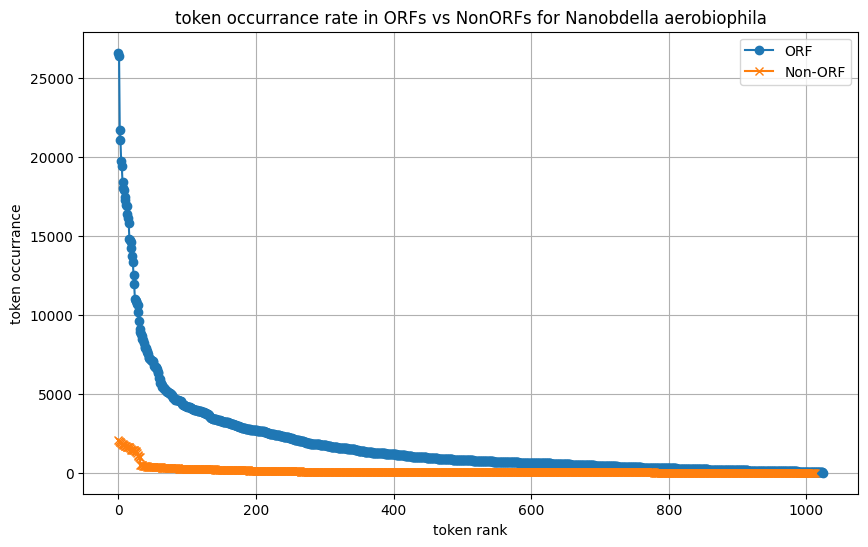

In [9]:
org = "Nanobdella aerobiophila"
processed_orf_data = load_processed_orf_data(org)
if processed_orf_data is not None:
    print(f"{org} processed ORFs: {processed_orf_data.head()}...")  

    genome_sequence = load_genome_sequence(f"{org.replace(' ', '_')}_processed.txt")
    orf_positions = mark_orf_positions(processed_orf_data, len(genome_sequence))

    k = 3
    orf_kmer_overlap, non_orf_kmer_overlap = align_orfs_with_kmers(orf_positions, genome_sequence, k)
    print(f"total ORF kmer overlaps: {len(orf_kmer_overlap)}")
    print(f"ORF kmer overlap (first 10): {orf_kmer_overlap[:10]}")
    print(f"total nonORF kmer overlaps: {len(non_orf_kmer_overlap)}")
    print(f"nonORF kmer overlap (first 10): {non_orf_kmer_overlap[:10]}")

    tokens = [genome_sequence[i:i+k] for i in range(len(genome_sequence) - k + 1)]
    print(f"total tokens: {len(tokens)}")
    print(f"first 10 tokens: {tokens[:10]}")

    plot_token_occurrence_rate_in_orfs(org, tokens, orf_kmer_overlap, non_orf_kmer_overlap, k)
else:
    print(f"processed ORF file not found for {org}")


In [10]:
"""here we transcribe the genome into mrna and translate it into amino acids. then we basically do everything we did in the cells above """

def genome_to_mRNA(genome):
    dna = Seq(genome)
    mrna = dna.transcribe()
    return mrna

def genome_to_aa(genome):
    genome = genome.replace(" ", "")
    dna = Seq(genome)
    amino_acids = dna.translate()
    return amino_acids

#convert genome to mRNA and amino acids
genome_sequence = load_genome_sequence(f"{org.replace(' ', '_')}_processed.txt") 
mRNA = genome_to_mRNA(genome_sequence)
mRNA_file_path = os.path.join(genome_sequences_dir, 'mRNA.txt')
with open(mRNA_file_path, 'w') as file:
    file.write(str(mRNA))

aa = genome_to_aa(genome_sequence)
aa_file_path = os.path.join(genome_sequences_dir, 'amino_acids.txt')
with open(aa_file_path, 'w') as file:
    file.write(str(aa))

def open_reading_frame(file_name, file_type):
    record = SeqIO.read(file_name, file_type)
    min_pro_len = 100
    results = []
    for strand, nuc in [(+1, record.seq), (-1, record.seq.reverse_complement())]:
        for frame in range(3):
            length = 3 * ((len(record) - frame) // 3)  
            for pro in nuc[frame:frame + length].split("*"):
                if len(pro) >= min_pro_len:
                    result = (
                        "%s...%s - length %i, strand %i, frame %i" % 
                        (pro[:30], pro[-3:], len(pro), strand, frame)
                    )
                    results.append(result)
    return results


def orf_transcribed(file_name, file_type):
    record = SeqIO.read(file_name, file_type)
    min_pro_len = 100
    results = []
    for strand, nuc in [(+1, record.seq), (-1, record.seq.reverse_complement())]:
        for frame in range(3):
            length = 3 * ((len(record) - frame) // 3)  
            for pro in nuc[frame:frame + length].transcribe().split("*"):
                if len(pro) >= min_pro_len:
                    result = (
                        "%s...%s - length %i, strand %i, frame %i" % 
                        (pro[:30], pro[-3:], len(pro), strand, frame)
                    )
                    results.append(result)
    return results

def orf_translated(file_name, file_type):
    record = SeqIO.read(file_name, file_type)
    min_pro_len = 100
    results = []
    for strand, nuc in [(+1, record.seq), (-1, record.seq.reverse_complement())]:
        for frame in range(3):
            length = 3 * ((len(record) - frame) // 3)  
            for pro in nuc[frame:frame + length].translate().split("*"):
                if len(pro) >= min_pro_len:
                    result = (
                        "%s...%s - length %i, strand %i, frame %i" % 
                        (pro[:30], pro[-3:], len(pro), strand, frame)
                    )
                    results.append(result)
    return results

k = 6
kmer_freqs = calculate_kmer_frequencies(genome_sequence, k)
check_inversion_robustness(org, genome_sequence, kmer_freqs, k)



Loaded genome sequence in 0.00 seconds
Calculated k-mer frequencies in 0.14 seconds
og compression factor for Nanobdella aerobiophila: 1.036676278587242
inverted compression factor for Nanobdella aerobiophila: 1.036676278587242


: 

In [11]:
organisms = [
    "Nanobdella aerobiophila",
    "Candidatus Karelsulcia muelleri",
    "Malassezia restricta",
    "Caenorhabditis elegans",
    "Ostreococcus lucimarinus CCE9901",
    "Theileria orientalis strain Shintoku",
    "Rice yellow mottle virus satellite"
]

for org in organisms:
    print(f"processing organism: {org}")
    
    genome_sequence = load_genome_sequence(f"{org.replace(' ', '_')}_processed.txt")
    
    kmer_freqs_all = calculate_kmer_frequencies(genome_sequence, k)
    
    processed_genome_path = os.path.join(subsampled_genomes_dir, f"{org.replace(' ', '_')}_subsampled.txt")
    optimal_vocab_size, optimal_compression_factor, compression_factors = heuristic_search_optimal_vocab_size(
        genome_sequence, processed_genome_path, kmer_freqs_all, initial_vocab_size=1000, step_size=1000, max_vocab_size=80000
    )
    print(f"optimal vocab size for {org}: {optimal_vocab_size}, compression factor: {optimal_compression_factor}")
    
    tokens = [genome_sequence[i:i+k] for i in range(len(genome_sequence) - k + 1)]
    orf_output_path = find_orfs(org)
    if orf_output_path:
        orf_data = load_orf_data(orf_output_path)
        processed_orf_data = process_orf_data(orf_data)
        save_processed_orf_data(processed_orf_data, org, file_format='excel')  
        orf_positions = mark_orf_positions(processed_orf_data, len(genome_sequence))
        orf_kmer_overlap, non_orf_kmer_overlap = align_orfs_with_kmers(orf_positions, genome_sequence, k)
        plot_token_occurrence_rate_in_orfs(org, tokens, orf_kmer_overlap, non_orf_kmer_overlap, k)
    else:
        print(f"ORF file not found for {org}")

    dna = open_reading_frame(genome_filename, "fasta")
    mrna = orf_transcribed(genome_filename, "fasta")
    aa = orf_translated(genome_filename, "fasta")
    print(dna)
    print("\n")
    print(mrna)
    print("\n")
    print(aa)

processing organism: Nanobdella aerobiophila
Loaded genome sequence in 0.00 seconds
